# Changes

Used loss func:

`0.5*bce_(F.sigmoid(input), target) - dice_coeff(F.sigmoid(input), target)`

Update for an extra conv block (512), and deconvolution.

This seems to produce worse predictions, and generalizes even worse on the leaderboard.

`not much change`

Updated Image size to be 512

`lowered loss 0.0583`

Removed Grayscale from labels

`no change`

Try to add Batch norm before the in convolution:

`loss to 0.0609`

Changed test resize interpolation to Image.BICUBIC (that seems to generate smoother preds). Just looking at some of the predictions though they definitely are overfitted.

Ok fuck i just realized hat for inference i used 128x128 even whn it was trained on bigger scales. lets retry 256, 512:

256 - `0.0617`

512 - `0.0614`

Ok adding batchnorm inbetween conv layer in the conv block:

`0.0639`

Next steps:

```
1 - lower to 50 epochs (done)
2 - reduce size of images to 256 (done)
3 - remove the 512 layer from the network (done)
(after doing these and adjusting the test set to be interpolated, to smooth) LB comse back up to 0.205)

4 - create a valdiation set to tune other hyper parameters.
5 - cross valdiation?
6 - use jaccard metric (interscetion over union) overlap
```

jaccard metric:

https://stackoverflow.com/questions/48260415/pytorch-how-to-compute-iou-jaccard-index-for-semantic-segmentation

https://github.com/amdegroot/ssd.pytorch/blob/master/layers/box_utils.py#L48

# Setup

In [1]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils import data

from torch.autograd import Variable, Function

from torchvision.datasets import ImageFolder
from torchvision import transforms, datasets

from PIL import Image
import numpy as np
import pandas as pd
from skimage.morphology import label
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.max_open_warning': 0})

# Constants

In [2]:
BATCH_SIZE = 16
IMG_PATH = '/home/yvan/projects/data_sci_bowl_2018/data'
N_EPOCHS = 50
FILTER_DEPTH = 1
IMG_SIZE = 512
LR = 0.001

# Data Processing

In [3]:
#create a custom imageloader that gets the name of the file as well
class YvanImageFolder(ImageFolder):
    def __getitem__(self,index):
        return super(YvanImageFolder, self).__getitem__(index), self.imgs[index]

In [4]:
# data process
img_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE,IMG_SIZE)),
    transforms.Grayscale(),
    transforms.ToTensor(),
])

img_dataset = YvanImageFolder(os.path.join(IMG_PATH, 'train_img'), img_transform)
img_loader = data.DataLoader(dataset=img_dataset,
                             batch_size=BATCH_SIZE,
                             shuffle=False,
                             num_workers=1)

In [5]:
# mask process
mask_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE,IMG_SIZE)),
    transforms.Grayscale(),
    transforms.ToTensor(),
])

mask_dataset = YvanImageFolder(os.path.join(IMG_PATH,'train_mask'),mask_transform)
mask_loader = data.DataLoader(dataset=mask_dataset,
                              batch_size=BATCH_SIZE,
                              shuffle=False,
                              num_workers=1)

In [6]:
for (img, img_name), (mask, mask_name) in zip(img_loader, mask_loader):
    a,b = img[0], mask[0]
    test_img = transforms.ToPILImage()(a[0])
    test_mask = transforms.ToPILImage()(b[0])
    print(a.size(), b.size())
    print(torch.max(a[0]), torch.min(a[0]), torch.max(b[0]), torch.min(b[0]))
    break

torch.Size([16, 1, 512, 512]) torch.Size([16, 1, 512, 512])
0.4156862795352936 0.0 1.0 0.0


In [7]:
# torch.std(torch.cat([x[0][0] for x in mask_loader]))

Ok so we can convert our stuff into tensors and convert them back into images.

# Unet model

referenced: https://github.com/milesial/Pytorch-UNet/blob/master/unet/unet_parts.py

In [8]:
from utils import *
    
### conv building block ###

class conv_block(nn.Module):
    def __init__(self, in_chan, out_chan):
        super(conv_block, self).__init__()
        self.conv = nn.Sequential(
            nn.BatchNorm2d(in_chan),
            nn.Conv2d(in_chan, out_chan, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(out_chan),
            nn.Conv2d(out_chan, out_chan, 3, padding=1),
            nn.ReLU()
        )
        
    def forward(self, x):
        x = self.conv(x)
        return x

### inputs and outputs ###

class in_conv(nn.Module):
    def __init__(self, in_chan, out_chan):
        super(in_conv, self).__init__()
        self.bn = nn.BatchNorm2d(in_chan)
        self.conv = conv_block(in_chan, out_chan)
        
    def forward(self, x):
        return self.conv(self.bn(x))
        
class out_conv(nn.Module):
    def __init__(self, in_chan, out_chan):
        super(out_conv, self).__init__()
        self.bn = nn.BatchNorm2d(in_chan)
        self.conv = nn.Conv2d(in_chan, out_chan, 1)
        self.activation = nn.Sigmoid()
        
    def forward(self, x):
        return self.activation(self.conv(self.bn(x)))
    
### actual con blocks ###

class conv_down(nn.Module):
    def __init__(self, in_chan, out_chan):
        super(conv_down, self).__init__()
        self.pool_conv = nn.Sequential(
            conv_block(in_chan, out_chan),
            nn.MaxPool2d(2)
        )
        
    def forward(self, x):
        x = self.pool_conv(x)
        return x

class conv_up(nn.Module):
    def __init__(self, in_chan, out_chan):
        super(conv_up, self).__init__()
        self.conv_up = nn.ConvTranspose2d(in_chan, out_chan, 2, stride=2)
        self.conv = conv_block(2*out_chan, out_chan)
        self.bn = nn.BatchNorm2d(in_chan)
    
    def forward(self, x1, x2):
        x1 = self.bn(x1)
        x1 = self.conv_up(x1)
        x = torch.cat([x2,x1],dim=1)
        x = self.conv(x)
        return x

class unet1(nn.Module):
    def __init__(self, in_chan, out_chan):
        super(unet1, self).__init__()
        self.inc = in_conv(in_chan, 8)
        self.down0 = conv_down(8, 16)
        self.down1 = conv_down(16, 32)
        self.down2 = conv_down(32, 64)
        self.down3 = conv_down(64, 128)
        self.down4 = conv_down(128, 256)
        self.up2 = conv_up(256, 128)
        self.up3 = conv_up(128, 64)
        self.up4 = conv_up(64, 32)
        self.up5 = conv_up(32, 16)
        self.up6 = conv_up(16, 8)
        self.out = out_conv(8, out_chan)
        
    def forward(self, x):
        xn = self.inc(x)
        x0 = self.down0(xn)
        x1 = self.down1(x0)
        x2 = self.down2(x1)
        x3 = self.down3(x2)
        x4 = self.down4(x3)
        x = self.up2(x4, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        x = self.up5(x, x0)
        x = self.up6(x, xn)
        x = self.out(x)
        return x
    
def weights_init(m):
    if type(m) == nn.Conv2d or type(m) == nn.ConvTranspose2d:
        nn.init.xavier_uniform(m.weight, gain=np.sqrt(2))
        nn.init.constant(m.bias,0.0)
    elif type(m) == nn.BatchNorm2d:
        m.weight.data.uniform_(1.0,0.02)
        m.bias.data.zero_()

creating model with 1948749 params and intial param sum 1065.569166958332
training epoch 10, epoch loss 0.07241781978380113
training epoch 20, epoch loss 0.0677134660737855
training epoch 30, epoch loss 0.06568888752233415
training epoch 40, epoch loss 0.06480044694173903
training epoch 50, epoch loss 0.06429181141512734
lowest loss: 0.06391448279221852


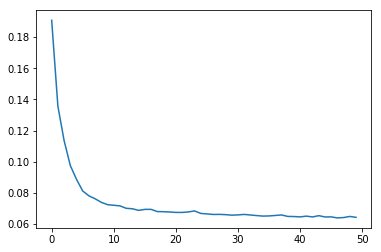

In [9]:
# create a unet
unet = unet1(FILTER_DEPTH, FILTER_DEPTH)
unet.apply(weights_init)
opti = optim.Adam(unet.parameters(), lr=LR, betas=(0.5,0.99))
loss = BCEDiceLoss()

nparams = sum([param.nelement() for param in unet.parameters()])
psum = check_param_sum(unet)
print(f'creating model with {nparams} params and intial param sum {psum}')

if torch.cuda.is_available():
    unet.cuda()
    loss.cuda()

losses = []

for epoch in range(N_EPOCHS):
    epoch_loss = []
    e = epoch+1
    for (batch, batch_name), (mask_batch, mask_name) in zip(img_loader, mask_loader):
        image_batch = to_variable(batch[0])
        labels = to_variable(mask_batch[0])

        x = unet(image_batch)
        l = loss(x, labels)
        epoch_loss.append(l.data[0])
        l.backward()
        opti.step()
        unet.zero_grad()
    mean_epoch_loss = np.mean(epoch_loss)
    losses.append(mean_epoch_loss)
    if not e % 10: print(f'training epoch {e}, epoch loss {mean_epoch_loss}')
    epoch_loss = []

lowestloss = min(losses)
print(f'lowest loss: {lowestloss}')
plt.plot(losses)
plt.show()

In [10]:
# model_file = 'models/model_feb252018_5:02.pkl'
# torch.save(unet, model_file)
# unet = torch.load(model_file)

# Examining Predictions

In [10]:
#make a less memory intensive inference dataloader (small batch size)
BATCH_SIZE_INF = 8
# data process
img_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE,IMG_SIZE)),
    transforms.Grayscale(),
    transforms.ToTensor(),
])

img_dataset = YvanImageFolder(os.path.join(IMG_PATH, 'train_img'), img_transform)
img_loader = data.DataLoader(dataset=img_dataset,
                             batch_size=BATCH_SIZE_INF,
                             shuffle=False,
                             num_workers=1)


# mask process
mask_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE,IMG_SIZE)),
    transforms.Grayscale(),
    transforms.ToTensor(),
])

mask_dataset = YvanImageFolder(os.path.join(IMG_PATH,'train_mask'),mask_transform)
mask_loader = data.DataLoader(dataset=mask_dataset,
                              batch_size=BATCH_SIZE_INF,
                              shuffle=False,
                              num_workers=1)

# FOR TEST SET

test_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE,IMG_SIZE)),
    transforms.Grayscale(),
    transforms.ToTensor()
])


test_transform_size = transforms.Compose([
    transforms.ToTensor()
])

test_dataset = YvanImageFolder(os.path.join(IMG_PATH, 'test_img'), test_transform)
test_loader = data.DataLoader(dataset=test_dataset,
                             batch_size=BATCH_SIZE_INF,
                             shuffle=False,
                             num_workers=1)


test_sizes = YvanImageFolder(os.path.join(IMG_PATH, 'test_img'), test_transform_size)
test_sizes_loader = data.DataLoader(dataset=test_sizes,
                             batch_size=1,
                             shuffle=False,
                             num_workers=1)

In [11]:
predicted_masks = []
actual_masks = []
names = []
for (batch, batch_name), (mask_batch, mask_name) in zip(img_loader, mask_loader):
    image_batch = to_variable(batch[0])
    labels = to_variable(mask_batch[0])
    names.extend(batch_name[0])
    x = unet(image_batch)
    for i, l in zip(x.data, labels.data):
        predicted_masks.append(transforms.ToPILImage()(i.cpu()))
        actual_masks.append(transforms.ToPILImage()(l.cpu()))
        
assert len(predicted_masks) == len(actual_masks)
assert len(predicted_masks) == len(names)

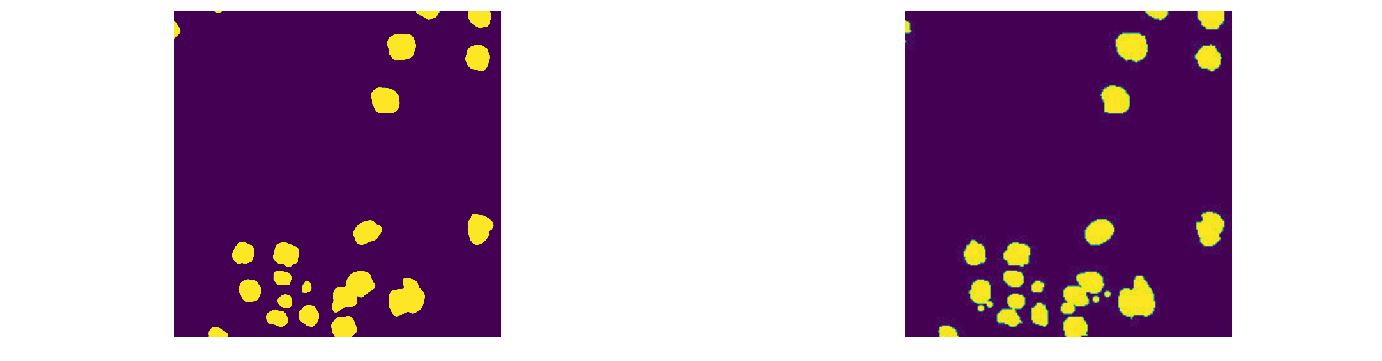

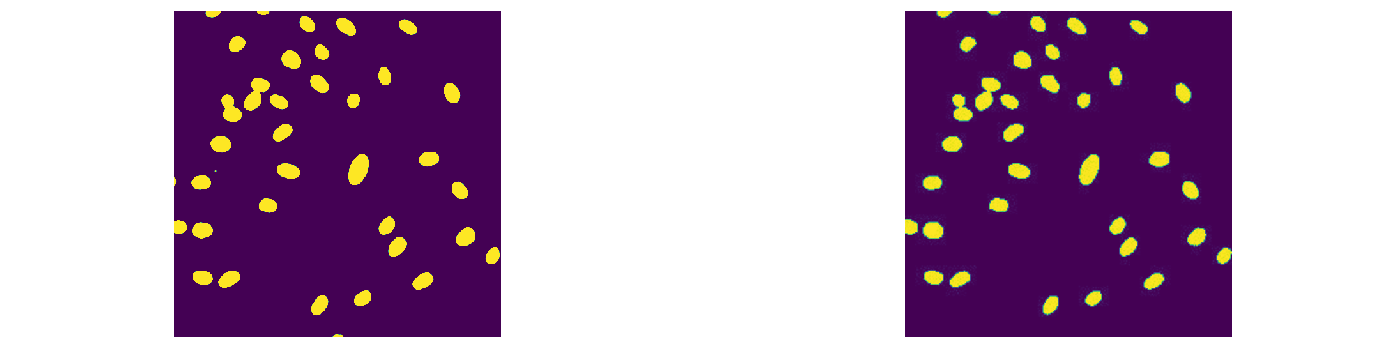

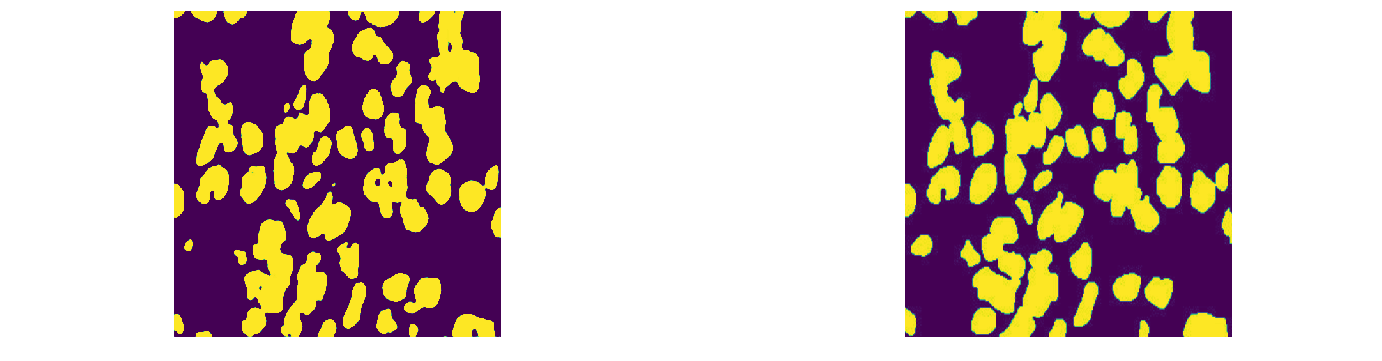

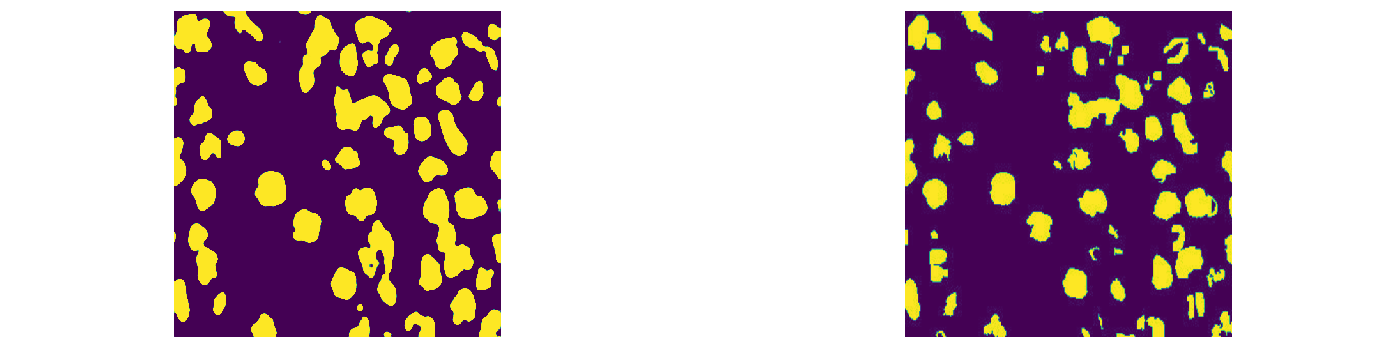

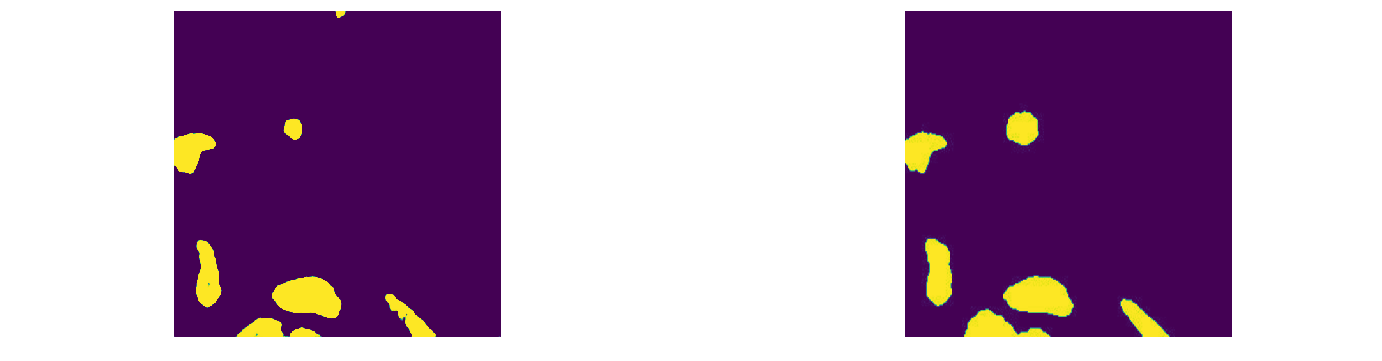

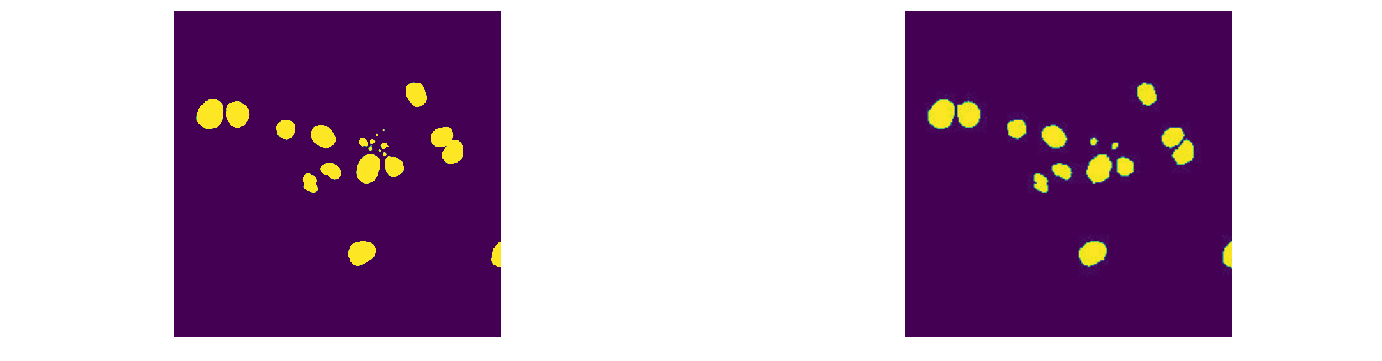

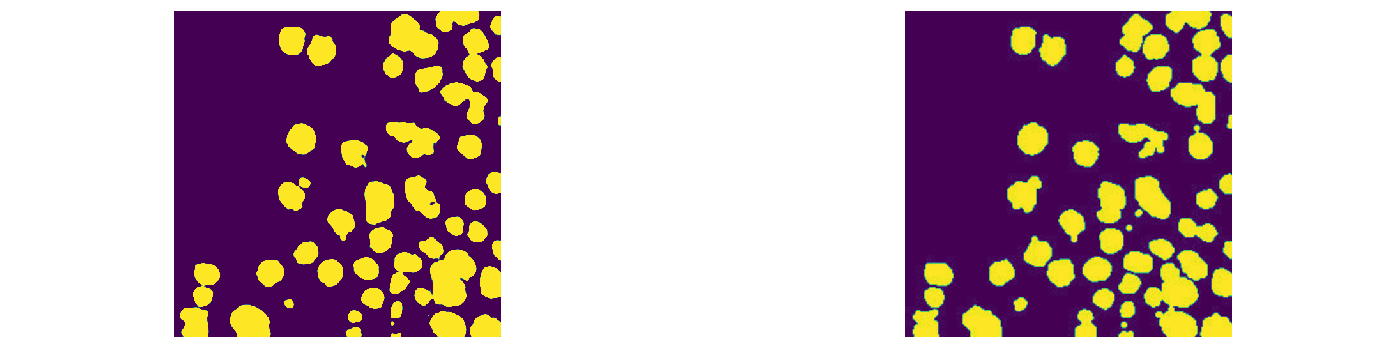

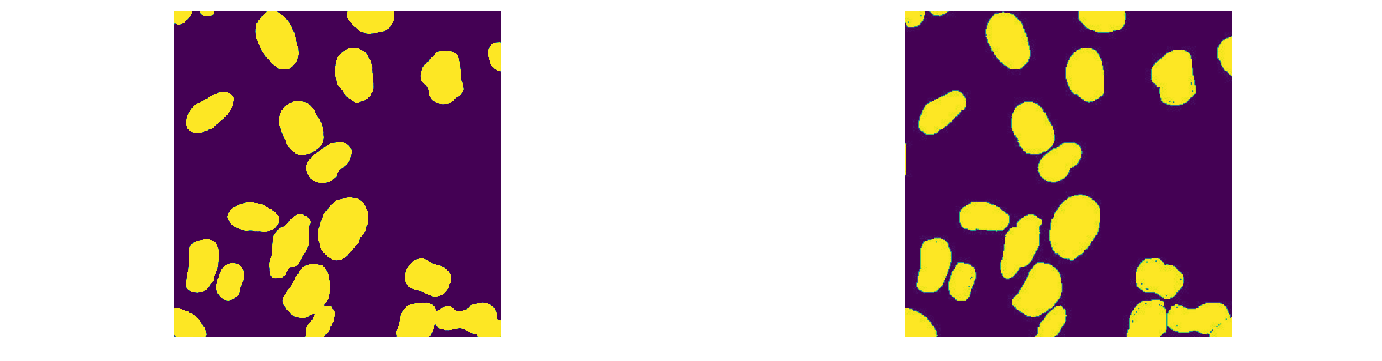

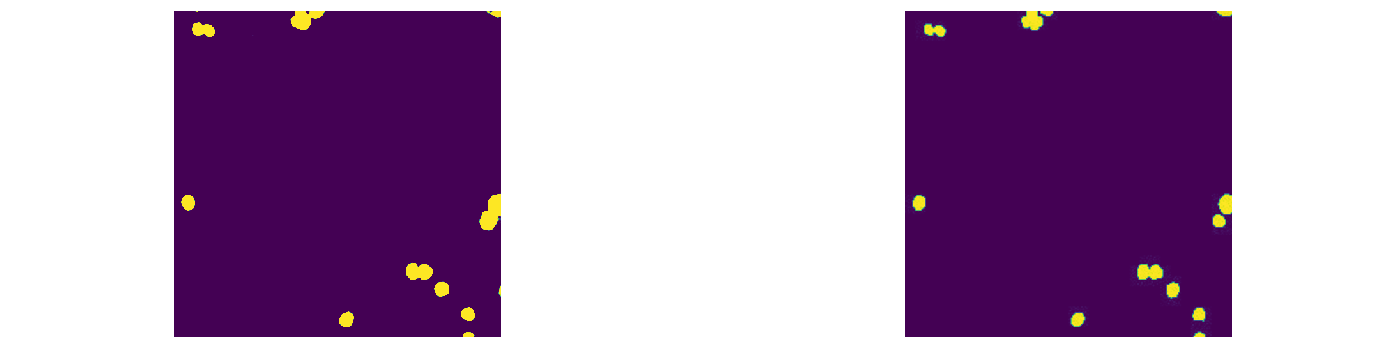

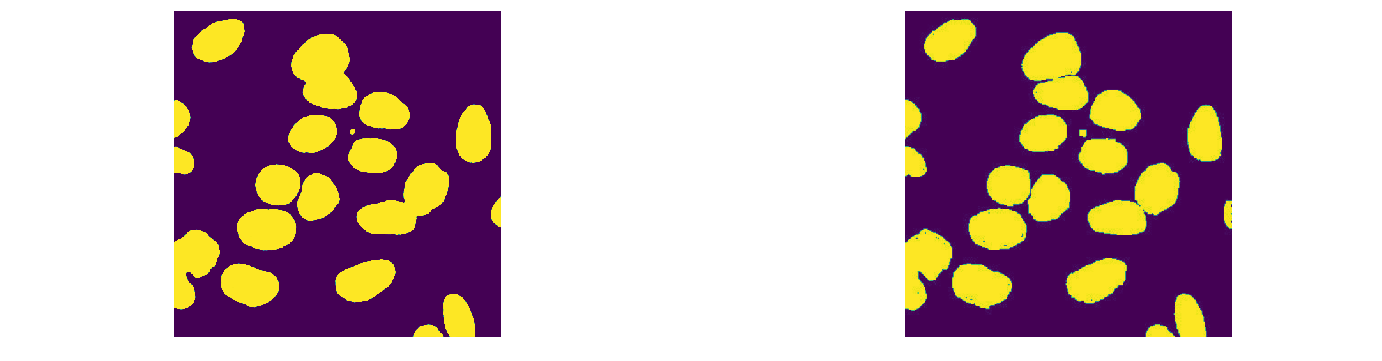

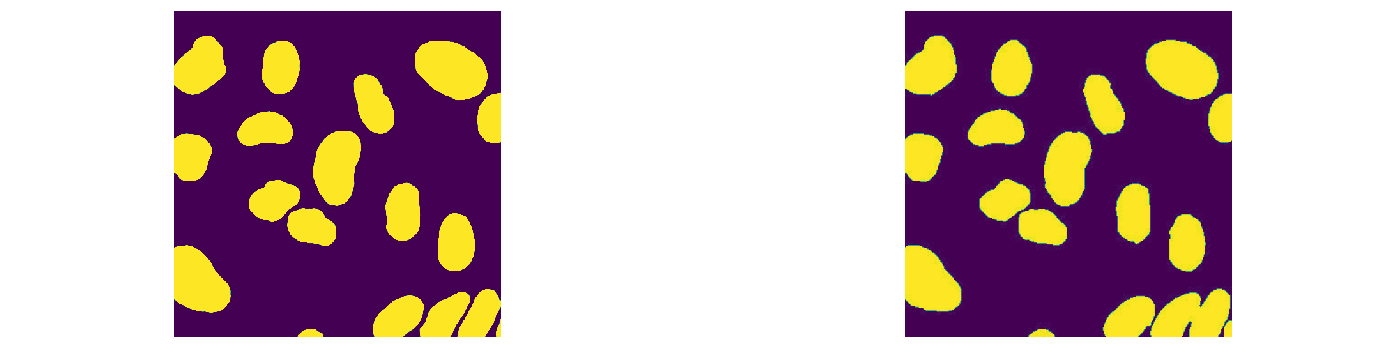

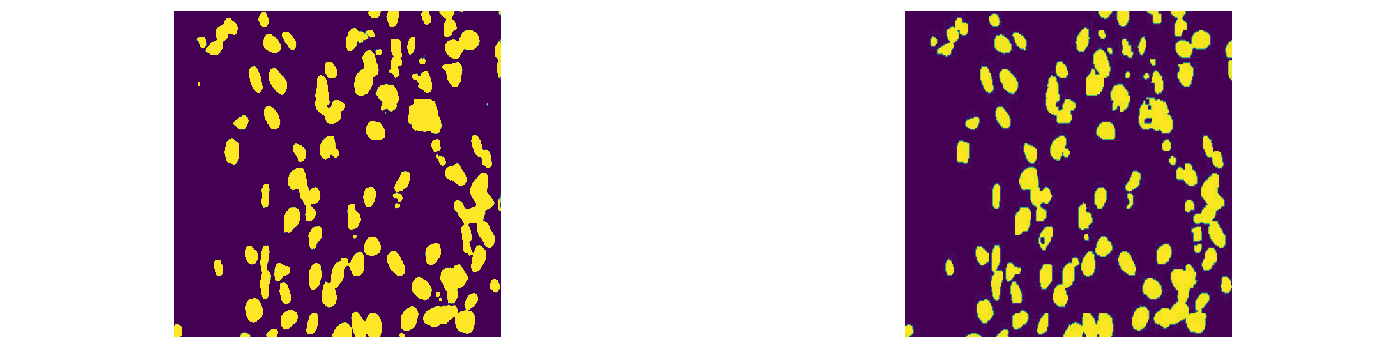

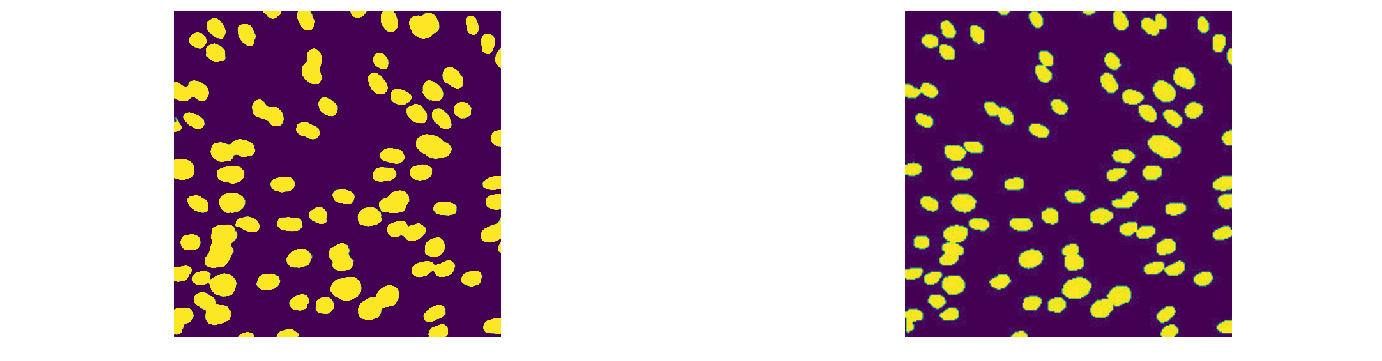

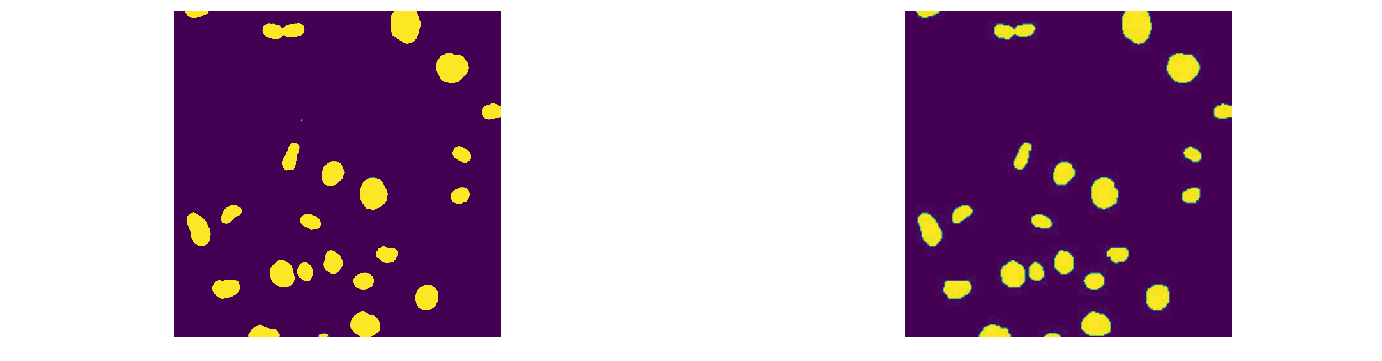

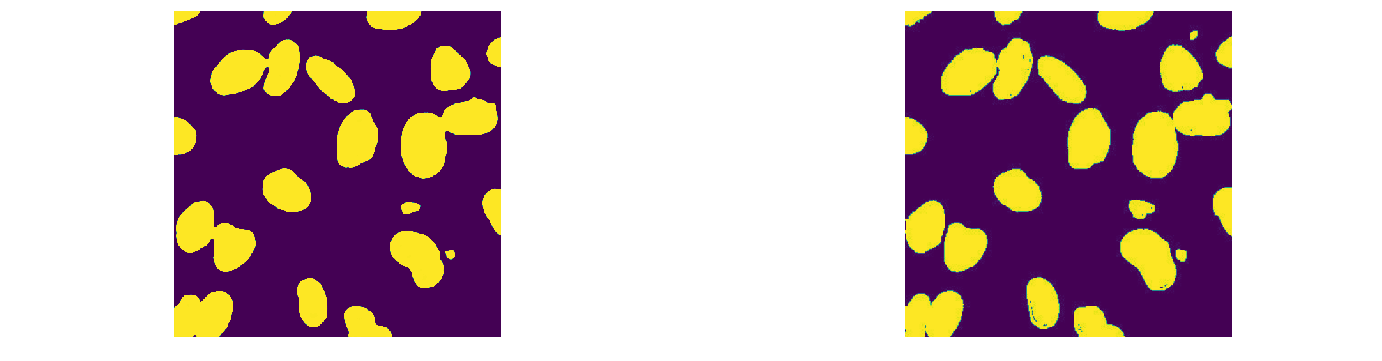

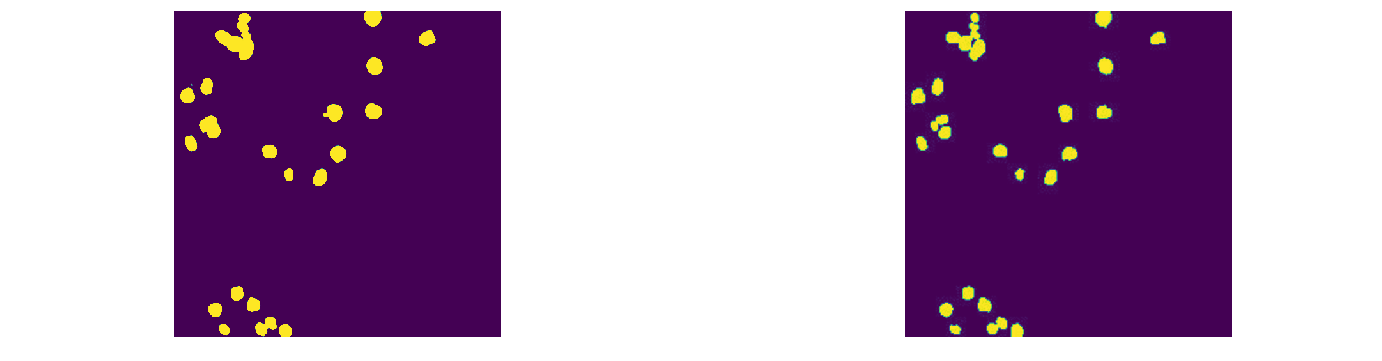

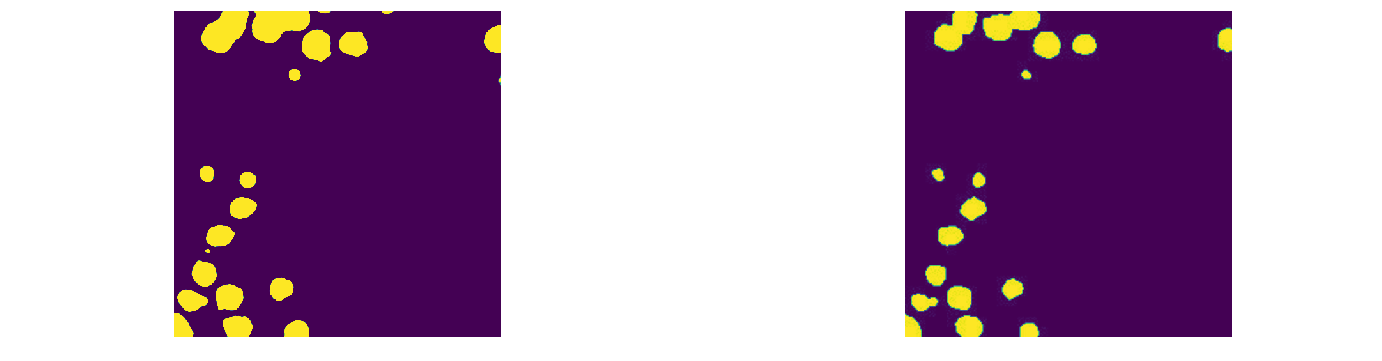

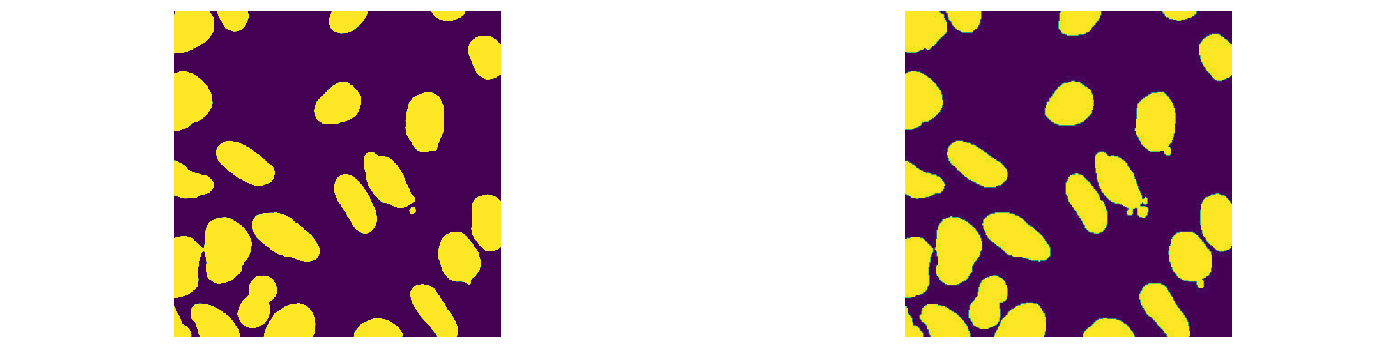

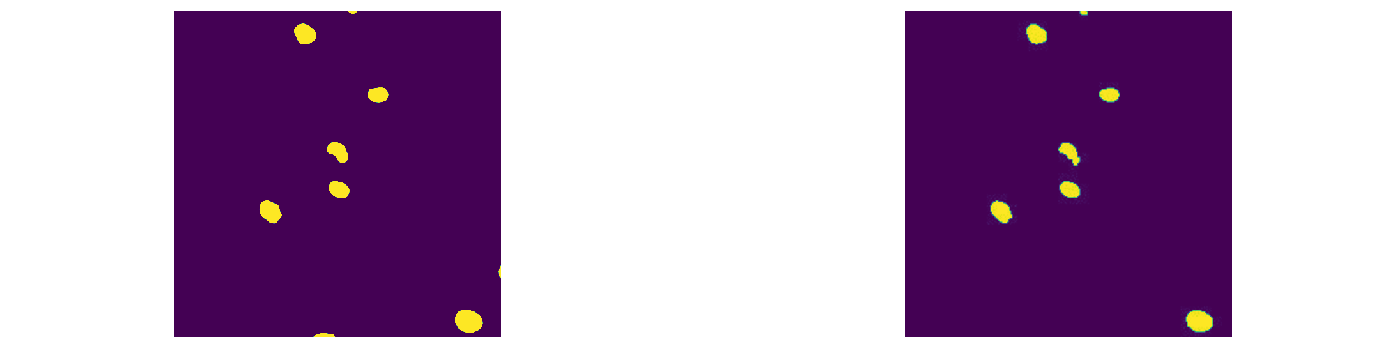

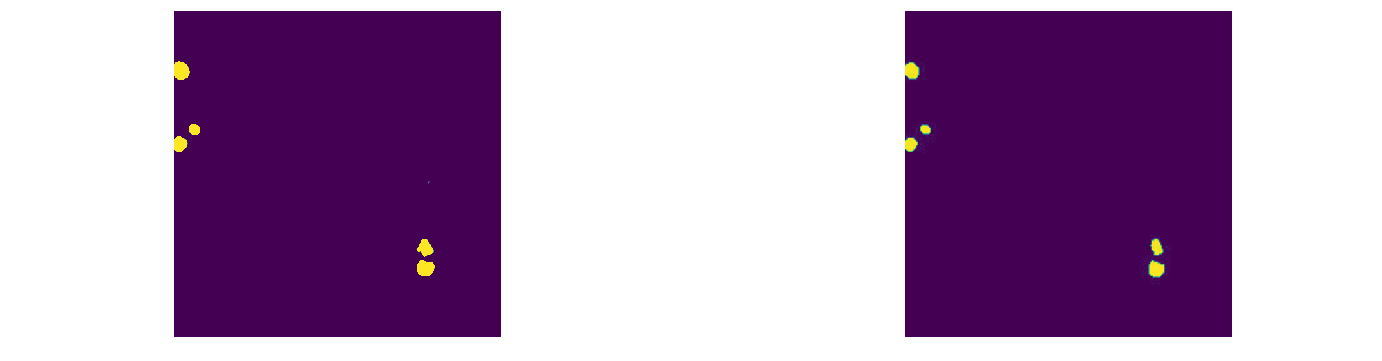

In [12]:
def show_n(img_files, n=6):
    _, ax = plt.subplots(1, n, sharex='col', sharey='row', figsize=(24,6))
    
    for i, img_file in enumerate(img_files):
        ax[i].imshow(img_file)
        ax[i].axis('off')
        
for pred,actual in zip(predicted_masks[:20], actual_masks[:20]):
    show_n([np.asarray(pred), np.asarray(actual)],n=2)

In [13]:
assert pred.mode == actual.mode

# Generating test predictions

In [14]:
sizes_in_order = [tuple(batch[0].size()[2:]) for batch, paths in test_sizes_loader]

In [15]:
predicted_names = []
predicted_test = []
ct = 0

for batch, paths in test_loader:
    predicted_names += list(paths[0])
    image_batch = to_variable(batch[0])
    x = unet(image_batch)
    for i in x.data:
        size = sizes_in_order[ct]
        im = transforms.ToPILImage()(i.cpu())
        im = im.resize((size[1], size[0]), resample=Image.BICUBIC)
        predicted_test.append(im)
        ct += 1

In [16]:
for i in range(len(sizes_in_order)): 
    assert sizes_in_order[i] == np.asarray(predicted_test[i].convert('1')).shape

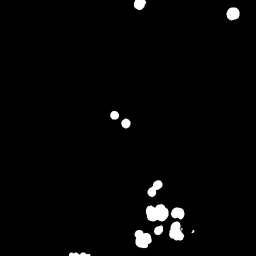

In [18]:
predicted_test[4]

# Make a submission

In [19]:
import pandas as pd

def rle_encoding(x):
    dots = np.where(x.T.flatten() == 1)[0]
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1): run_lengths.extend((b + 1, 0))
        run_lengths[-1] += 1
        prev = b
    return run_lengths

def prob_to_rles(x, cutoff=0.5):
    lab_img = label(x > cutoff)
    for i in range(1, lab_img.max() + 1):
        yield rle_encoding(lab_img == i)

test_names = []
test_rles = [] 
for i, (p, path) in enumerate(zip(predicted_test, predicted_names)):
    supposed_size = sizes_in_order[i]
    pred_slide = np.asarray(np.array(p)/255)
    name = os.path.splitext(os.path.basename(path))[0].split('_')[0]
    rles = list(prob_to_rles(pred_slide))
    test_rles.extend(rles)
    test_names.extend([name]*len(rles))

In [20]:
sub = pd.DataFrame()
sub['ImageId'] = test_names
sub['EncodedPixels'] = pd.Series(test_rles).apply(lambda x: ' '.join(str(y) for y in x))
sub.tail(n=15)

,ImageId,EncodedPixels
2696,fe9adb627a6f45747c5a8223b671774791ededf9364f65...,19143 5 19398 8 19653 9 19910 9 20166 9 20422 ...
2697,fe9adb627a6f45747c5a8223b671774791ededf9364f65...,27081 1 27334 7 27589 9 27845 10 28101 10 2835...
2698,fe9adb627a6f45747c5a8223b671774791ededf9364f65...,30415 6 30669 10 30924 12 31180 13 31435 14 31...
2699,fe9adb627a6f45747c5a8223b671774791ededf9364f65...,15065 2 15319 6 15572 10 15827 12 16083 13 163...
2700,fe9adb627a6f45747c5a8223b671774791ededf9364f65...,26585 5 26838 9 27093 12 27348 13 27603 15 278...
2701,fe9adb627a6f45747c5a8223b671774791ededf9364f65...,41178 6 41433 10 41688 12 41944 13 42199 15 42...
2702,fe9adb627a6f45747c5a8223b671774791ededf9364f65...,20708 7 20963 10 21218 12 21474 13 21730 13 21...
2703,fe9adb627a6f45747c5a8223b671774791ededf9364f65...,7421 1 7674 5 7925 11 8179 14 8432 17 8686 19 ...
2704,fe9adb627a6f45747c5a8223b671774791ededf9364f65...,63738 3 63742 1 63987 1 63989 12 64241 16 6449...
2705,fe9adb627a6f45747c5a8223b671774791ededf9364f65...,247 6 502 7 757 7 1016 1


In [21]:
sub.to_csv(os.path.join(IMG_PATH, 'submissions','feb252018_4.csv'), index=False)

Ok this scores 0.293 on the LB. I attribute this to the incraesed number of predictions (more actual segmentation).

Stuff to try in the next one. Using the mean_iou metric itself. Valdation sets for more hyperparameter tuning. Different interpolation methods. We should stop evaluating on the LB and start using a valdation set (maybe 10%).